# Lunar Lander 

## implementing policy gradients: algoritmo Básico "on policy"

In [1]:
import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 

from torch.distributions import Categorical  
from torch.autograd import Variable          # para instanciar variables diferenciables en los gradientes: backpropagation

### Explorando el enviroment

In [2]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind= False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    )


np.random.seed(42)
torch.random.seed = 42

env.reset()

print(f'El espacio de obervaciones para el Lunar lander es de: {env.observation_space.shape[0]}')
print(f'Espacio de acciones para el Lunar Lander: {env.action_space.n}')

El espacio de obervaciones para el Lunar lander es de: 8
Espacio de acciones para el Lunar Lander: 4


In [3]:
state = env.reset()
print(state[0])
print('\n')

next_state, reward, done, truncated, _ = env.step(action=env.action_space.sample())
print(next_state)
print(reward)
print(done)
print(truncated)
print(_)

[-0.00341778  1.4082876  -0.34619662 -0.11700253  0.00396712  0.07841863
  0.          0.        ]


[-0.00685902  1.406464   -0.34795043 -0.08106493  0.00774785  0.07562257
  0.          0.        ]
0.3195041021013026
False
False
{}


### Definiendo la policy network

In [4]:
class PolicyNet(nn.Module): 
    def __init__(self, input_size, num_actions):
        super(PolicyNet, self).__init__() 

        # arquitectura de la red 
        self.fc1 = nn.Linear(in_features=input_size, out_features=16*input_size)
        self.fc2 = nn.Linear(in_features=16*input_size, out_features=32*input_size)
        self.fc3 = nn.Linear(in_features= 32*input_size, out_features=num_actions)

    def forward(self, x):
        # Se definen las operaciones del forward
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=-1)  # Especificar la dimensión
        
        return x 

### Definiendo hiper parámetros

In [5]:
episodes = 10_000
max_steps_in_episode = 1000
episode_duration = []      # almacenar la duracion de los episodios
episode_total_rewards = []  # almacenar la recompensa media de cada episodio
model_path = 'LunarLander_pg.pth'

# hiper parametros del entrenamiento
learning_rate = 0.001
gamma = 0.99
batch_size = 32

# se define el enviroment y la policy
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind= False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    )

policy_net = PolicyNet(input_size=env.observation_space.shape[0], num_actions=env.action_space.n)

# optimizador 
optimizer = torch.optim.Adam(
    params=policy_net.parameters(), 
    lr= learning_rate
)

state_pool = []
action_pool = []
reward_pool = []
steps = 0

### Entrenamiento

In [6]:
def process_state(state): 
    state = torch.from_numpy(state).float()
    return Variable(state)

In [7]:
# print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)

PolicyNet(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [8]:
from RL_tools import discount_rewards, normalize_rewards

# bucle de episodios
for eps in range(episodes): 

    print(f'\nInicializando el episodio: {eps}')
    state = env.reset()
    state = process_state(state=state[0]).to(device)

    episode_rewards = []
    # bucle de trayectorias
    for t in range(max_steps_in_episode): 

        # seleccionar una accion dado el estado y la policy actual
        probs = policy_net(state)
        m = Categorical(probs= probs)
        action = m.sample()
        action = action.item()

        # ejecuttamos un step en el entorno con nuestra action
        next_state, reward, done, truncated,  _ = env.step(action=action)
        episode_rewards.append(reward)
        
        # almacenamos experiencia
        state_pool.append(state)
        action_pool.append(float(action))
        
        # procesamos el siguiente estado
        state = process_state(next_state).to(device)
        steps += 1

        # si llegamos al estado terminal se rompe el bucle
        if done: break

    episode_duration.append(t+1)
    episode_total_rewards.append(np.sum(episode_rewards))
    print(f'Finaliza el episodio: {eps} con:\nduración: {t} steps\nrecompensa total: {round(np.sum(episode_rewards),2)}\n\n')

  # calcular la recompensa acumulada para cada step EN CADA EPISODIO
    discounted_eps_reward = [0]*len(episode_rewards)
    discount_reward = 0
    for n in reversed(range(len(episode_rewards))): 
        discount_reward = episode_rewards[n] + gamma*discount_reward
        discounted_eps_reward[n] = discount_reward
    
    # añadimos los discount rewards por episodio 
    reward_pool.extend(discounted_eps_reward)

    # update policy; actualizamos la policy cada 5 trayectorias recopiladas
    if eps >0 and eps% batch_size == 0: 
        print('\nActualizando la policy...')

        # normalizamos la recompensa DE todo el batch
        # batch_normalized_rewards = normalize_rewards(full_batch_rewards=reward_pool)
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        norm_batch_rewards = [(reward_pool[n] - reward_mean)/(reward_std+ 1e-9) for n in range(len(reward_pool))]

        # actualizar la policy
        optimizer.zero_grad()
        total_loss = 0

        for n in range(steps): 
            
            # seleccionar la experiencia del step actual
            state = state_pool[n]
            action = Variable(torch.tensor(action_pool[n], dtype=torch.float32)).to(device)
            reward = norm_batch_rewards[n]

            probs = policy_net(state)           # le damos a la policy el nuevo estado 
            m = Categorical(probs=probs)        # sacamos las probs para cada accion
            loss = -m.log_prob(action)*reward   # negative score  function x reward; calculamos la pérdida de cada accion por su recompensa
            total_loss += loss
            
        # calcular gradientes
        total_loss.backward()

        # actualizamos los pesos en direccion de los gradientes
        optimizer.step()  
        print('\tPolicy actualizada con éxito!\n')   

        # limpiamos la memoria (cada vez que termino un entreno)
        state_pool = []
        action_pool = []
        reward_pool = []
        steps = 0


Inicializando el episodio: 0
Finaliza el episodio: 0 con:
duración: 63 steps
recompensa total: -92.81



Inicializando el episodio: 1
Finaliza el episodio: 1 con:
duración: 75 steps
recompensa total: -271.03



Inicializando el episodio: 2
Finaliza el episodio: 2 con:
duración: 73 steps
recompensa total: -114.12



Inicializando el episodio: 3
Finaliza el episodio: 3 con:
duración: 107 steps
recompensa total: -101.37



Inicializando el episodio: 4
Finaliza el episodio: 4 con:
duración: 138 steps
recompensa total: -312.75



Inicializando el episodio: 5
Finaliza el episodio: 5 con:
duración: 87 steps
recompensa total: -200.55



Inicializando el episodio: 6
Finaliza el episodio: 6 con:
duración: 63 steps
recompensa total: -78.56



Inicializando el episodio: 7
Finaliza el episodio: 7 con:
duración: 93 steps
recompensa total: -178.06



Inicializando el episodio: 8
Finaliza el episodio: 8 con:
duración: 78 steps
recompensa total: -63.18



Inicializando el episodio: 9
Finaliza el episo

KeyboardInterrupt: 

In [9]:
torch.save(policy_net.state_dict(), model_path)

### Monitoreando los resultados

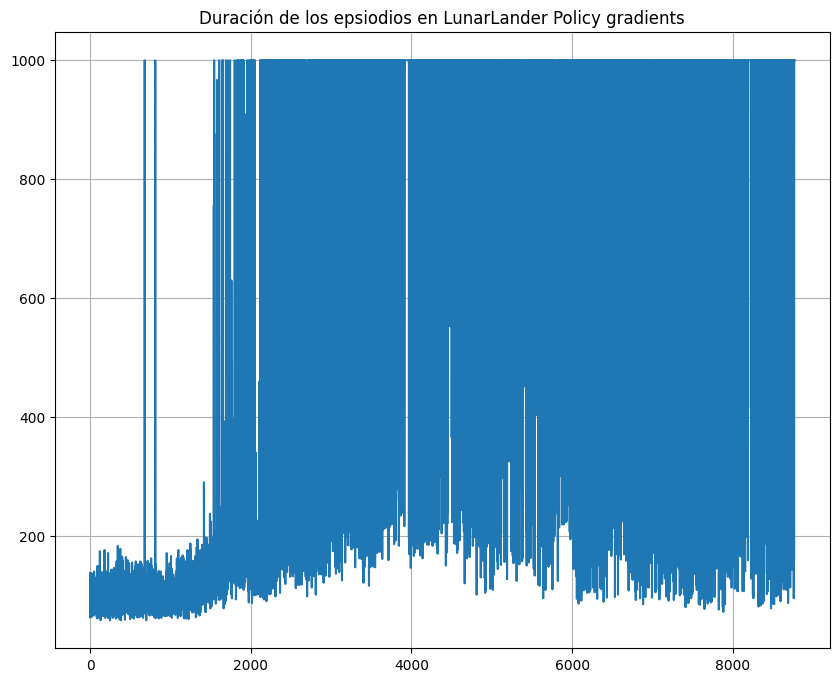

In [10]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 8))
plt.plot(range(len(episode_duration)), episode_duration)
plt.title('Duración de los epsiodios en LunarLander Policy gradients')
plt.grid()
plt.show()

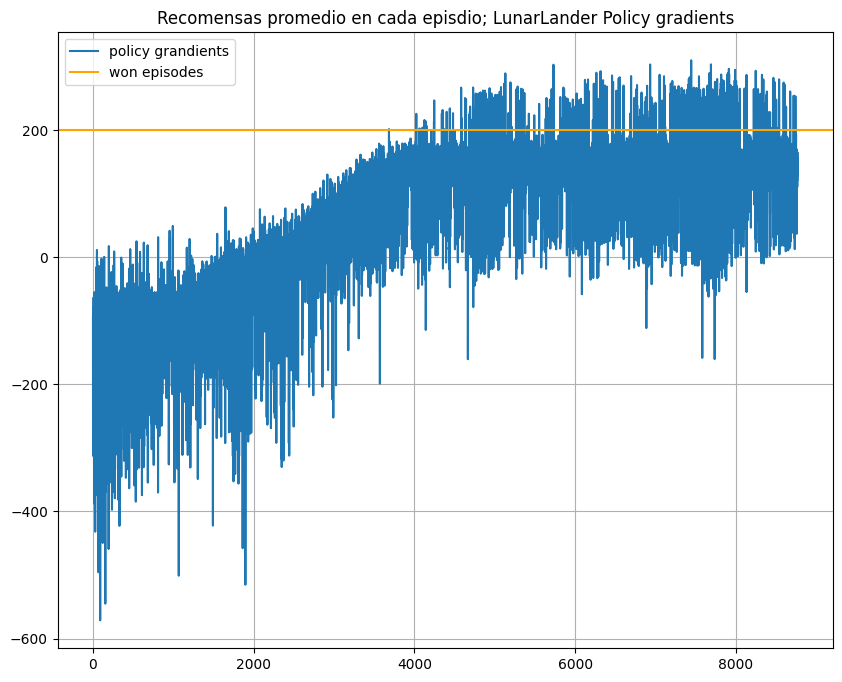

In [11]:
plt.figure(figsize= (10, 8))
plt.plot(range(len(episode_total_rewards)), episode_total_rewards, label= 'policy grandients')
plt.axhline(y= 200, color= 'orange', linestyle= '-', label= 'won episodes')
plt.title('Recomensas promedio en cada episdio; LunarLander Policy gradients')
plt.legend(loc= 'best')
plt.grid()
plt.show()

## Evaluando el modelo

In [12]:
evaluation_eps = 10
max_steps_in_evaluation = 400

env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind= False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode ='human'
)

model = PolicyNet(input_size=env.observation_space.shape[0], num_actions=env.action_space.n)
model.load_state_dict(torch.load(model_path))

##bucle de episodios
for eps in range(evaluation_eps): 
    print('Inicializa episodio: ', eps)
    state = env.reset()
    state = process_state(state=state[0]).to(device)
    episode_rewards = []

# bucle de trayectorias
    for t in range(max_steps_in_evaluation): 

        #seleccionar una accion dado el estado y la policy actual
        
        probs = model(state)
        # print(probs)
        m = Categorical(probs= probs)
        # print(m)
        action = m.sample()
        # print(action)
        action = action.item()
        # print(action)
        env.render()
        # ejecuttamos un step en el entorno con nuestra action
        next_state, reward, done, truncated,  _ = env.step(action=action)
        episode_rewards.append(reward)

        # actualizamos el estado
        state = process_state(next_state).to(device)

        if done: break
    print(f'Recompensa total del episodio: {np.sum(episode_rewards)} en {t+1} steps\n')

Inicializa episodio:  0
Recompensa total del episodio: 147.93966855849925 en 400 steps

Inicializa episodio:  1
Recompensa total del episodio: 153.83013205720198 en 400 steps

Inicializa episodio:  2
Recompensa total del episodio: 166.4104386539268 en 400 steps

Inicializa episodio:  3
Recompensa total del episodio: 206.68545683461878 en 400 steps

Inicializa episodio:  4
Recompensa total del episodio: 167.3606953660635 en 400 steps

Inicializa episodio:  5
Recompensa total del episodio: 131.36036562309525 en 400 steps

Inicializa episodio:  6
Recompensa total del episodio: 177.5103342744663 en 400 steps

Inicializa episodio:  7
Recompensa total del episodio: 193.9741909002224 en 400 steps

Inicializa episodio:  8
Recompensa total del episodio: 183.6649916727572 en 400 steps

Inicializa episodio:  9
Recompensa total del episodio: 190.33774213750365 en 400 steps

